In [1]:
%matplotlib inline
import os
import time
import theano
import lasagne
import numpy as np
import theano.tensor as T
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from lasagne.layers import InputLayer, DenseLayer, DropoutLayer

Using gpu device 1: Tesla K40c (CNMeM is enabled with initial size: 40.0% of memory, cuDNN 5005)


# MNIST Test - Neural Network

In [2]:
# Constants
NUM_EPOCHS = 50
BATCH_SIZE = 10
LEARNING_RATE = 0.001

In [3]:
def load_dataset():
    dataset = fetch_mldata('MNIST original')
    X = dataset['data']
    no_classes = len(np.unique(dataset['target']))
    X = normalize(X, norm='l2') # l2 norm used.. also zero mean unit var. is commented below
    #     X = (X - X.mean()) / X.std()
    Y = dataset['target']
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=41)
    return dict(X_train=X_train,
               y_train=y_train,
               X_test=X_test,
               y_test=y_test,
               classes=no_classes)
data = load_dataset()
NUM_CLASSES = data['classes']

/home/ilker/anaconda2/envs/theano/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


In [4]:
def build_mlp(Xs, classnum):
    tanh = lasagne.nonlinearities.tanh
    softmax = lasagne.nonlinearities.softmax
    
    l_in = InputLayer(shape=Xs.shape)
    # Two hidden layers with 300, probably easy overfit ?
    l_dense1 = DenseLayer(l_in, num_units=300, nonlinearity=tanh)
    l_dense2 = DenseLayer(l_dense1, num_units=300, nonlinearity=tanh)
    l_class = DenseLayer(l_dense2, num_units=classnum, nonlinearity=softmax)
    
    return l_class

model = build_mlp(data['X_train'], classnum=NUM_CLASSES)
model_params = lasagne.layers.get_all_params(model, trainable=True)

In [5]:
def build_functions():
    X = T.matrix(dtype=theano.config.floatX)
    y = T.ivector()
    
    # training output
    output_train = lasagne.layers.get_output(model, X, deterministic=False)

    # evaluation output. Also includes output of transform for plotting
    output_eval = lasagne.layers.get_output(model, X, deterministic=True)

    sh_lr = theano.shared(lasagne.utils.floatX(LEARNING_RATE))
    cost = T.mean(T.nnet.categorical_crossentropy(output_train, y))
    
    updates = lasagne.updates.adam(cost, model_params, learning_rate=sh_lr)
    
    train = theano.function([X, y], [cost, output_train], updates=updates, allow_input_downcast=True)
    eval = theano.function([X], [output_eval], allow_input_downcast=True)
    
    return train, eval, sh_lr

train, eval, sh_lr = build_functions()

In [6]:
def train_epoch(X, y):
    # History Keeping
    param_output = []
    disc_output = []
    # History
    num_samples = X.shape[0]
    num_batches = int(np.ceil(num_samples / float(BATCH_SIZE)))
    costs = []
    correct = 0
    for i in range(num_batches):
        idx = range(i*BATCH_SIZE, np.minimum((i+1)*BATCH_SIZE, num_samples))
        X_batch = X[idx]
        y_batch = y[idx]
        cost, output_train = train(X_batch, y_batch)
        costs += [cost]
        preds = np.argmax(output_train, axis=-1)
        correct += np.sum(y_batch == preds)
    
    return np.mean(costs), correct / float(num_samples)


def eval_epoch(X, y):
    output_eval = eval(X)
    preds = np.argmax(output_eval, axis=-1)
    acc = np.mean(preds == y)
    return acc

In [7]:
np.set_printoptions(formatter={'float': '{: 0.4f}'.format}, suppress=True)
train_accs, test_accs = [], []
total_time = 0
try:
    for n in range(NUM_EPOCHS):
        start_time = time.time()
        train_cost, train_acc = train_epoch(data['X_train'], data['y_train'])
        test_acc = eval_epoch(data['X_test'], data['y_test'])
        test_accs += [test_acc]
        train_accs += [train_acc]

        if (n+1) % 20 == 0:
            new_lr = sh_lr.get_value() * 0.90
            print "New LR:", new_lr
            sh_lr.set_value(lasagne.utils.floatX(new_lr))

        time_spent = time.time() - start_time
        total_time += time_spent
        print "Epoch {0}: T.cost {1:0.6f}, Train acc {2:0.6f}, test acc {3:0.6f}, took {4:.3} sec.".format(
                n, train_cost, train_acc, test_acc, time_spent)

except KeyboardInterrupt:
    pass
print "\nTotal time spent: {0:.5} seconds\nTraing Acc: {1}\nTest Acc: {2}\n".format(total_time, train_acc, test_acc) 

Epoch 0: T.cost 0.329192, Train acc 0.903982, test acc 0.927286, took 4.53 sec.
Epoch 1: T.cost 0.186114, Train acc 0.944143, test acc 0.945429, took 4.47 sec.
Epoch 2: T.cost 0.130504, Train acc 0.959625, test acc 0.956000, took 4.44 sec.
Epoch 3: T.cost 0.098751, Train acc 0.969500, test acc 0.958929, took 4.44 sec.
Epoch 4: T.cost 0.077273, Train acc 0.976232, test acc 0.957857, took 4.44 sec.
Epoch 5: T.cost 0.063683, Train acc 0.980089, test acc 0.962286, took 4.44 sec.
Epoch 6: T.cost 0.052072, Train acc 0.983429, test acc 0.966429, took 4.44 sec.
Epoch 7: T.cost 0.045231, Train acc 0.985250, test acc 0.962071, took 4.44 sec.
Epoch 8: T.cost 0.040640, Train acc 0.986339, test acc 0.964857, took 4.46 sec.
Epoch 9: T.cost 0.038535, Train acc 0.987482, test acc 0.968857, took 4.53 sec.
Epoch 10: T.cost 0.032530, Train acc 0.988804, test acc 0.967000, took 4.45 sec.
Epoch 11: T.cost 0.030020, Train acc 0.990018, test acc 0.965143, took 4.45 sec.
Epoch 12: T.cost 0.027922, Train acc 0

# MNIST Test - Random Forest Classifier

In [8]:
rf = RandomForestClassifier(n_estimators=20)
rf.fit(data['X_train'], data['y_train'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

# Neural Network vs Random Forest

In [9]:
# Random Forest
prediction = rf.predict(data['X_test'])
prediction = np.floor(prediction +.5)
tp = sum(prediction == data['y_test'])
fp = sum(prediction != data['y_test'])
acc = accuracy_score(data['y_test'], prediction)
mis_calc = np.array(np.where(prediction != data['y_test'])).flatten()

print "Random Forest Classifier:"
print "True Positive {0}\nFalse Positive {1}\nAcc: {2:.4f}".format(tp, fp, acc)
print "Mis-Calculated: {0}".format(len(mis_calc))

# Neural Network
output_eval = eval(data['X_test'])
output_eval = np.argmax(output_eval, axis=-1).squeeze()
tp_nn = sum(output_eval == data['y_test'])
fp_nn = sum(output_eval != data['y_test'])
acc_nn = accuracy_score(data['y_test'], output_eval.squeeze())
mis_calc_nn = np.array(np.where(output_eval != data['y_test'])).flatten()


print "\nMLP Classifier:"
print "True Positive {0}\nFalse Positive {1}\nAcc: {2:.4f}".format(tp_nn, fp_nn, acc_nn)
print "Mis-Calculated: {0}".format(len(mis_calc_nn))

Random Forest Classifier:
True Positive 13412
False Positive 588
Acc: 0.9580
Mis-Calculated: 588

MLP Classifier:
True Positive 13662
False Positive 338
Acc: 0.9759
Mis-Calculated: 338


# Mis Calculated Digits

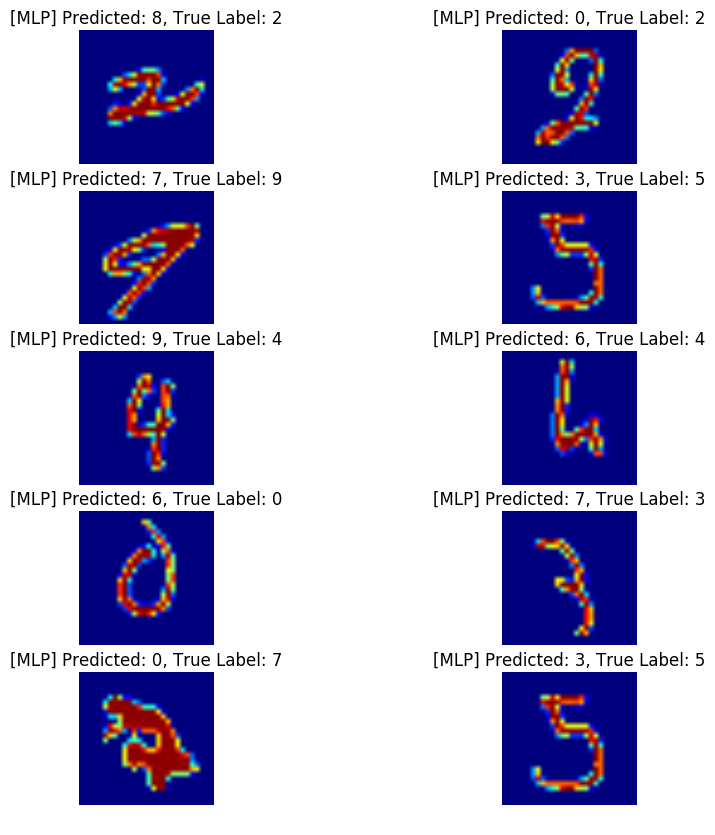

In [10]:
# Miss Calculated NN
plt.figure(figsize=(10, 10))
for i in range(10):
    # Choose a random mis classified digit
    nn_miss = np.random.choice(mis_calc_nn)
    nn_miss_img = data['X_test'][nn_miss].reshape((28, 28))
    nn_miss_label = data['y_test'][nn_miss]
    plt.subplot(5, 2, i+1)
    plt.imshow(nn_miss_img)
    plt.axis('off')
    plt.title('[MLP] Predicted: ' + str(int(output_eval[nn_miss])) + ', True Label: ' + str(int(nn_miss_label)))

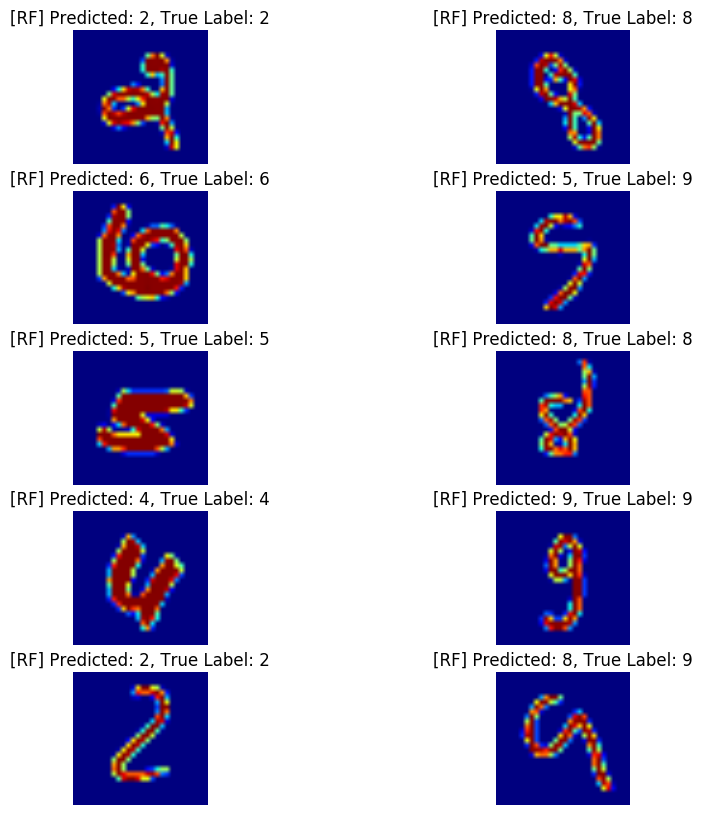

In [11]:
# Miss Calculated RF
plt.figure(figsize=(10, 10))
for i in range(10):
    # Choose a random mis classified digit
    rf_miss = np.random.choice(mis_calc)
    rf_miss_img = data['X_test'][rf_miss].reshape((28, 28))
    rf_miss_label = data['y_test'][rf_miss]
    plt.subplot(5, 2, i+1)
    plt.imshow(rf_miss_img)
    plt.axis('off')
    plt.title('[RF] Predicted: ' + str(int(output_eval[rf_miss])) + ', True Label: ' + str(int(rf_miss_label)))